Welcome to the 3rd iteration. Here, we'll be focusing on feature engineering.

In [365]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.preprocessing import PolynomialFeatures

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Important functons

In [366]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, info=True):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [367]:
def apply_operations_to_columns(df1, df2, columns):
    new_df1_addition = df1[columns].copy()
    new_df2_addition = df2[columns].copy()

    new_df1_subtraction = df1[columns].copy()
    new_df2_subtraction = df2[columns].copy()

    new_df1_division = df1[columns].copy()
    new_df2_division = df2[columns].copy()


    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                new_col1 = f"{col1}_plus_{col2}"
                new_col2 = f"{col1}_plus_{col2}"
                new_df1_addition[new_col1] = df1[col1] + df1[col2]
                new_df2_addition[new_col2] = df2[col1] + df2[col2]
    
    new_df1_addition["SalePrice"] = df1["SalePrice"]
    new_df1_addition_corr = new_df1_addition.corr()["SalePrice"].sort_values()


    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                new_col1 = f"{col1}_minus_{col2}"
                new_col2 = f"{col1}_minus_{col2}"
                new_df1_subtraction[new_col1] = df1[col1] - df1[col2]
                new_df2_subtraction[new_col2] = df2[col1] - df2[col2]
    
    new_df1_subtraction["SalePrice"] = df1["SalePrice"]
    new_df1_subtraction_corr = new_df1_subtraction.corr()["SalePrice"].sort_values()


    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                new_col1 = f"{col1}_divided_by_{col2}"
                new_col2 = f"{col1}_divided_by_{col2}"
                new_df1_division[new_col1] = df1[col1] / df1[col2]
                new_df2_division[new_col2] = df2[col1] / df2[col2]

    new_df1_division["SalePrice"] = df1["SalePrice"]
    new_df1_division_corr = new_df1_division.corr()["SalePrice"].sort_values()

    correlations = pd.concat([new_df1_addition_corr.to_frame(), new_df1_subtraction_corr.to_frame(), new_df1_division_corr.to_frame()])
    corr_filtered = pd.concat([correlations.head(20), correlations.tail(20)])


    return corr_filtered


In [368]:
def polynomial_feature(df1, columns, target, degree):
    # Make a new dataframe for polynomial features
    poly_features = df1[columns]

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=degree)

    # Train the polynomial features
    poly_features = poly_transformer.fit_transform(poly_features)
    
    # Create a dataframe of the features
    poly_features = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names_out(columns))

    # Add in the target
    poly_features[target] = df1[target]

    print("Poly features shape is", poly_features.shape)

    # Find the correlations with the target
    poly_corrs = poly_features.corr()[target].sort_values().to_frame()
    corr = pd.concat([poly_corrs.head(20), poly_corrs.tail(20)])

    return corr

# Doing the thing

In [369]:
train = pd.read_csv("Datasets/train.csv")
test = pd.read_csv("Datasets/test.csv")

In [370]:
train = train.drop(["Id", "Utilities"], axis=1)
test = test.drop(["Id", "Utilities"], axis=1)

In [371]:
# Gets the categorical and numerical columns
categorical = [c for c in train.columns 
               if train.dtypes[c] == 'object']

numerical = [c for c in train.columns 
             if train.dtypes[c] != 'object']

In [372]:
corr = train[numerical].corr()

In [373]:
high_corr_pairs = []
thres_pos = 0.8
thres_neg = -0.3

# Assuming 'corr' is a pandas DataFrame containing correlation values
for col in corr:
    # Extract columns with correlations above thres_pos or below thres_neg
    correlated_cols = corr.index[(corr[col] > thres_pos) | (corr[col] < thres_neg)]
    
    for correlated_col in correlated_cols:
        if correlated_col != col:
            correlation_value = corr.at[col, correlated_col]  # Access correlation value directly from the DataFrame
            high_corr_pairs.append((col, correlated_col, correlation_value))

# Separate positive and negative correlation pairs
pairs_pos, pairs_neg = [], []
unique_pairs = set()

for pair in high_corr_pairs:
    col, ccol, correlation_value = pair
    inverse_pair = (ccol, col, correlation_value)
    
    # Check for uniqueness to avoid duplicates
    if pair not in unique_pairs and inverse_pair not in unique_pairs:
        unique_pairs.add(pair)
        
        # Categorize pairs into positive and negative correlations
        if correlation_value > 0:
            pairs_pos.append(pair)
        else:
            pairs_neg.append(pair)

pairs = pairs_pos + pairs_neg     
print(f"Pair Numerical Columns Highest and Lowest Correlations (treshold is {thres_pos} and {thres_neg})\n")   
for pair in pairs:
    col, ccol, correlation_value = pair
    print(f'{col:<15} {ccol:<15} {correlation_value:.3f}')


Pair Numerical Columns Highest and Lowest Correlations (treshold is 0.8 and -0.3)

YearBuilt       GarageYrBlt     0.826
TotalBsmtSF     1stFlrSF        0.820
GrLivArea       TotRmsAbvGrd    0.825
GarageCars      GarageArea      0.882
MSSubClass      LotFrontage     -0.386
OverallCond     YearBuilt       -0.376
OverallCond     GarageYrBlt     -0.324
YearBuilt       EnclosedPorch   -0.387
BsmtFinSF1      BsmtUnfSF       -0.495
BsmtUnfSF       BsmtFullBath    -0.423


In [374]:
print("Correlations with Target Column\n")

thres_pos = 0.5
thres_neg = -0.1

neg, neut, pos = [], [], []
for i in range(len(corr['SalePrice'])):
    cor = corr['SalePrice'][i]
    if cor > thres_pos:
        pos.append([cor, corr['SalePrice'].index[i]])
    elif cor < thres_neg:
        neg.append([cor, corr['SalePrice'].index[i]])
    else:
        neut.append([cor, corr['SalePrice'].index[i]])

print(f"Positive Correlations (treshold is {thres_pos})")
for cor in pos:
    score, col = cor
    if col == 'SalePrice': continue
    print(f'{col:<15}: {score:.3f}')

print(f"\nNegative Correlations (treshold is {thres_neg})")
for cor in neg:
    score, col = cor
    print(f'{col:<20}: {score:.3f}')

Correlations with Target Column

Positive Correlations (treshold is 0.5)
OverallQual    : 0.791
YearBuilt      : 0.523
YearRemodAdd   : 0.507
TotalBsmtSF    : 0.614
1stFlrSF       : 0.606
GrLivArea      : 0.709
FullBath       : 0.561
TotRmsAbvGrd   : 0.534
GarageCars     : 0.640
GarageArea     : 0.623

Negative Correlations (treshold is -0.1)
KitchenAbvGr        : -0.136
EnclosedPorch       : -0.129


## Feature Engineering on Year column

In [375]:
train["GarageYrBlt"] = train["GarageYrBlt"].fillna(0)
test["GarageYrBlt"] = test["GarageYrBlt"].fillna(0)

In [376]:
columns = train.columns[train.columns.str.contains("Year") | train.columns.str.contains("Yr")]
print("Nan values on the columns (train and test):\n")
print(train[columns].isna().sum())
print()
print(test[columns].isna().sum())

corr_with_saleprice_df = apply_operations_to_columns(train, test, columns).sort_values(by="SalePrice")

# remove duplicated index
corr_with_saleprice_df = corr_with_saleprice_df.drop_duplicates(keep='first')
corr_with_saleprice_df

Nan values on the columns (train and test):

YearBuilt       0
YearRemodAdd    0
GarageYrBlt     0
YrSold          0
dtype: int64

YearBuilt       0
YearRemodAdd    0
GarageYrBlt     0
YrSold          0
dtype: int64


,SalePrice
YrSold_minus_YearBuilt,-0.523350
YrSold_divided_by_YearBuilt,-0.518687
YrSold_minus_YearRemodAdd,-0.509079
YrSold_divided_by_YearRemodAdd,-0.508552
YrSold_divided_by_GarageYrBlt,-0.483964
YrSold_minus_GarageYrBlt,-0.261441
YearRemodAdd_divided_by_YearBuilt,-0.217154
YearRemodAdd_divided_by_GarageYrBlt,-0.087888
YrSold,-0.028923
YearBuilt_divided_by_GarageYrBlt,0.176044


In [377]:
polynomial_feature(train, columns, "SalePrice", degree=3)

Poly features shape is (1460, 36)


,SalePrice
YrSold^3,-0.028924
YrSold^2,-0.028923
YrSold,-0.028923
GarageYrBlt YrSold^2,0.261218
GarageYrBlt YrSold,0.261293
GarageYrBlt,0.261366
YearRemodAdd GarageYrBlt YrSold,0.281934
YearRemodAdd GarageYrBlt,0.282008
GarageYrBlt^2 YrSold,0.284928
GarageYrBlt^2,0.285000


In [378]:
train[columns].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,1971.267808,1984.865753,1868.739726,2007.815753
std,30.202904,20.645407,453.697295,1.328095
min,1872.000000,1950.000000,0.000000,2006.000000
25%,1954.000000,1967.000000,1958.000000,2007.000000
50%,1973.000000,1994.000000,1977.000000,2008.000000
75%,2000.000000,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,2010.000000


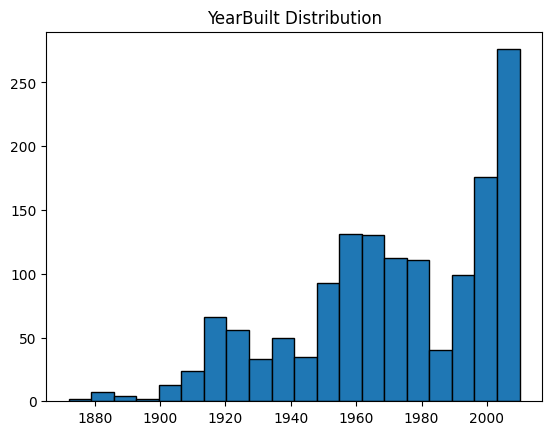

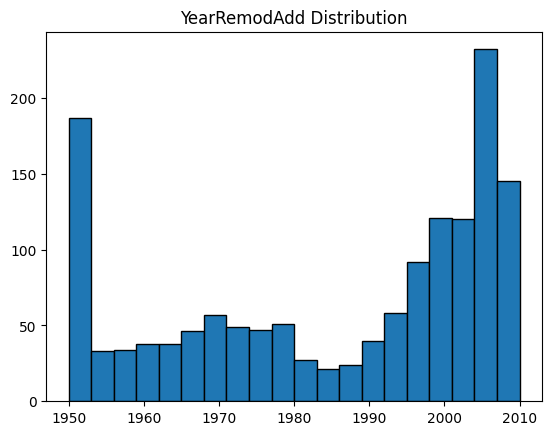

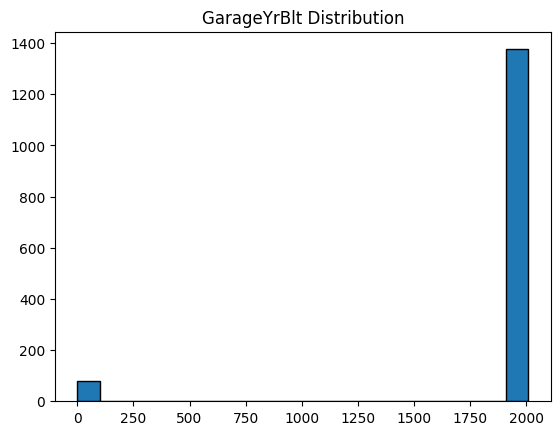

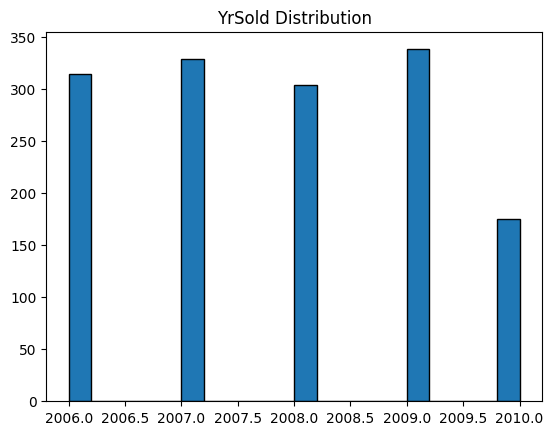

In [379]:
for col in columns:
    plt.title(f"{col} Distribution")
    train[col].hist(edgecolor='black', bins=20)
    plt.grid()
    plt.show()

In [380]:
yr_train = train.copy()
yr_test = test.copy()

train["YearBuilt_minus_YrSold"] = (train["YearBuilt"]-train["YrSold"]) * -1
test["YearBuilt_minus_YrSold"] = (test["YearBuilt"]-test["YrSold"]) * -1

train["YearRemodAdd_divided_by_YrSold"] = train["YearRemodAdd"] / train['YrSold']
test["YearRemodAdd_divided_by_YrSold"] = test["YearRemodAdd"] / test['YrSold']

## Feature Engineering on Area column

In [381]:
train["MasVnrArea"] = train["MasVnrArea"].fillna(train["MasVnrArea"].median())
test["MasVnrArea"] = test["MasVnrArea"].fillna(test["MasVnrArea"].median())

test["GarageArea"] = test["GarageArea"].fillna(test["GarageArea"].median())

In [382]:
columns = train.columns[train.columns.str.contains("Area")]
print("Nan values on the columns:\n")
print(train[columns].isna().sum())
print()
print(test[columns].isna().sum())
corr_with_saleprice_df = apply_operations_to_columns(train, test, columns).sort_values(by="SalePrice")

# remove duplicated index
corr_with_saleprice_df = corr_with_saleprice_df.drop_duplicates(keep='first')
corr_with_saleprice_df

Nan values on the columns:

LotArea       0
MasVnrArea    0
GrLivArea     0
GarageArea    0
PoolArea      0
dtype: int64

LotArea       0
MasVnrArea    0
GrLivArea     0
GarageArea    0
PoolArea      0
dtype: int64


,SalePrice
LotArea_divided_by_GrLivArea,-0.010763
PoolArea_divided_by_MasVnrArea,-0.010611
GrLivArea_divided_by_LotArea,-0.002416
GarageArea_divided_by_PoolArea,0.006036
LotArea_divided_by_GarageArea,0.009317
PoolArea_divided_by_GrLivArea,0.045690
PoolArea_divided_by_GarageArea,0.066454
PoolArea_divided_by_LotArea,0.079996
GarageArea_divided_by_GrLivArea,0.089553
PoolArea,0.092404


In [383]:
polynomial_feature(train, columns, "SalePrice", degree=3)

Poly features shape is (1460, 57)


,SalePrice
MasVnrArea^2 PoolArea,-0.005570
LotArea MasVnrArea PoolArea,-0.005396
MasVnrArea GarageArea PoolArea,-0.004602
MasVnrArea GrLivArea PoolArea,-0.004054
MasVnrArea PoolArea,-0.001150
MasVnrArea PoolArea^2,-0.000695
LotArea^2 PoolArea,0.014646
LotArea GarageArea PoolArea,0.032444
LotArea GrLivArea PoolArea,0.044341
LotArea PoolArea,0.057601


In [384]:
y_train_label = train["SalePrice"]
train = train.drop("SalePrice", axis=1)
train, test = train.align(test, join='inner', axis=1)
train["SalePrice"] = y_train_label

In [385]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearBuilt_minus_YrSold,YearRemodAdd_divided_by_YrSold,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,...,NaN,NaN,0,2,2008,WD,Normal,5,0.997510,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,...,NaN,NaN,0,5,2007,WD,Normal,31,0.984554,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,...,NaN,NaN,0,9,2008,WD,Normal,7,0.997012,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,...,NaN,NaN,0,2,2006,WD,Abnorml,91,0.982054,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,...,NaN,NaN,0,12,2008,WD,Normal,8,0.996016,250000


In [386]:
train[categorical].isna().sum()[train[categorical].isna().sum()>0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [387]:
test[categorical].isna().sum()[test[categorical].isna().sum()>0]

MSZoning           4
Alley           1352
Exterior1st        1
Exterior2nd        1
MasVnrType        16
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [388]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train.columns:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:

            print(f"Processing {col}")
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

Processing Street
Processing CentralAir
2 columns were label encoded.


In [389]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [390]:
train_labels = train['SalePrice']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the SalePrice back in
train['SalePrice'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (1460, 270)
Testing Features shape:  (1459, 269)


In [391]:
missing_values_table(train)

Your selected dataframe has 270 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,259,17.7


In [392]:
missing_values_table(test)

Your selected dataframe has 269 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,227,15.6
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
BsmtFinSF1,1,0.1
BsmtFinSF2,1,0.1
BsmtUnfSF,1,0.1
TotalBsmtSF,1,0.1
GarageCars,1,0.1


In [393]:
columns = missing_values_table(test, info=False).index[1:]

for col in columns:
    test[col] = test[col].fillna(test[col].mode().iloc[0])

In [395]:
# train.to_csv("Datasets/train_fe_le_ohe.csv", index=False)
# test.to_csv("Datasets/test_fe_le_ohe.csv", index=False)